In [ ]:
# dataloader.py
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader


class DHCDataset(Dataset):
    """ Devnagari Handwritten Character Dataset class """

    def __init__(self, npz_file, train=True):
        """
        Args:
        npz_file (string): Path to the NPZ file containing the DHCD
        """
        self.__dataset_npz = np.load(npz_file)
        self.train = train
        self.image_train = self.__dataset_npz['arr_0']
        self.label_train = self.__dataset_npz['arr_1']
        self.image_test = self.__dataset_npz['arr_2']
        self.label_test = self.__dataset_npz['arr_3']

    def __len__(self):
        """
        Returns dataset size
        """
        if self.train:
            return len(self.image_train)
        else:
            return len(self.image_test)

    def __getitem__(self, idx):
        """
        Returns indexed item
        """
        if self.train:
            img, label = self.image_train[idx, ...], self.label_train[idx]
        else:
            img, label = self.image_test[idx, ...], self.label_test[idx]

        # Converting numpy array to tensor, normalizing pixel range to 0 or 1
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0) / 255.0

        # Subtract 1 from label to make sure labels are in the range 0-45
        label = torch.tensor(label - 1, dtype=torch.long)

        return img, label

    def __repr__(self):
        repr_str = 'Devnagari Handwritten Character Dataset \n'
        repr_str += 'Training set contains {} images\n'.format(
            len(self.image_train))
        repr_str += 'Testing set contains {} images\n'.format(
            len(self.image_test))
        return repr_str


# Initializing dataset instances
train_dataset = DHCDataset(npz_file='dataset/dataset.npz', train=True)
test_dataset = DHCDataset(npz_file='dataset/dataset.npz', train=False)

print(train_dataset)
print(test_dataset)


# Checking the range of the labels
train_labels = train_dataset.label_train
test_labels = test_dataset.label_test

print("Unique training labels:", np.unique(train_labels))
print("Unique testing labels:", np.unique(test_labels))

Devnagari Handwritten Character Dataset 
Training set contains 78200 images
Testing set contains 13800 images

Devnagari Handwritten Character Dataset 
Training set contains 78200 images
Testing set contains 13800 images

Unique training labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]
Unique testing labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]


In [ ]:
# cnn_model.py
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Defining the convulational layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) # 1 channel, 32 filters
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # 32 channel, 64 filters
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # 64 channel, 128 filters
        self.pool = nn.MaxPool2d(2, 2) # Only keeps key features

        # Change the input size of fc1 to 8192
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 46)  # 46 output classes

        # Activation functions
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Forward pass through the layers
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))

        # Print shape to verify
        print(f"Output size before flattening: {x.shape}")

        # Flatten the tensor but keep the batch size
        x = x.view(x.size(0), -1)  # x.size(0) keeps the batch size (64)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


# Instantiating the model
model = CNNModel()
print(model)


CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=46, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)


In [ ]:
import torch.optim as optim

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()  # Set model to training mode
    total_images_trained = 0
    try:
        for epoch in range(num_epochs):
            running_loss = 0.0
            correct = 0
            total = 0
            print(f"Starting Epoch [{epoch+1}/{num_epochs}]")

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                # Zero the gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()

                # Calculate loss and accuracy
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Track the total number of images processed
                total_images_trained += labels.size(0)

            epoch_loss = running_loss / len(train_loader)
            accuracy = 100 * correct / total
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

    except KeyboardInterrupt:
        print(f"\nTraining interrupted by the user. Stopping...")
        print(f"Total images trained: {total_images_trained}")
        print(f"Epochs completed: {epoch}")

    print(f"Training complete. Total images trained: {total_images_trained}")

# Set up device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize dataloaders
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Train the model for 5 epoch
train_model(model, train_loader, criterion, optimizer, num_epochs=5)


Streaming output truncated to the last 5000 lines.
Output size before flattening: torch.Size([64, 128, 8, 8])
Output size before flattening: torch.Size([64, 128, 8, 8])
Output size before flattening: torch.Size([64, 128, 8, 8])
Output size before flattening: torch.Size([64, 128, 8, 8])
Output size before flattening: torch.Size([64, 128, 8, 8])
Output size before flattening: torch.Size([64, 128, 8, 8])
Output size before flattening: torch.Size([64, 128, 8, 8])
Output size before flattening: torch.Size([64, 128, 8, 8])
Output size before flattening: torch.Size([64, 128, 8, 8])
Output size before flattening: torch.Size([64, 128, 8, 8])
Output size before flattening: torch.Size([64, 128, 8, 8])
Output size before flattening: torch.Size([64, 128, 8, 8])
Output size before flattening: torch.Size([64, 128, 8, 8])
Output size before flattening: torch.Size([64, 128, 8, 8])
Output size before flattening: torch.Size([64, 128, 8, 8])
Output size before flattening: torch.Size([64, 128, 8, 8])
Outpu

In [ ]:
#evaluate.py
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

# Evaluate the model
evaluate_model(model, test_loader)


Output size before flattening: torch.Size([64, 128, 8, 8])
Output size before flattening: torch.Size([64, 128, 8, 8])
Output size before flattening: torch.Size([64, 128, 8, 8])
Output size before flattening: torch.Size([64, 128, 8, 8])
Output size before flattening: torch.Size([64, 128, 8, 8])
Output size before flattening: torch.Size([64, 128, 8, 8])
Output size before flattening: torch.Size([64, 128, 8, 8])
Output size before flattening: torch.Size([64, 128, 8, 8])
Output size before flattening: torch.Size([64, 128, 8, 8])
Output size before flattening: torch.Size([64, 128, 8, 8])
Output size before flattening: torch.Size([64, 128, 8, 8])
Output size before flattening: torch.Size([64, 128, 8, 8])
Output size before flattening: torch.Size([64, 128, 8, 8])
Output size before flattening: torch.Size([64, 128, 8, 8])
Output size before flattening: torch.Size([64, 128, 8, 8])
Output size before flattening: torch.Size([64, 128, 8, 8])
Output size before flattening: torch.Size([64, 128, 8, 8

Output size before flattening: torch.Size([64, 128, 8, 8])


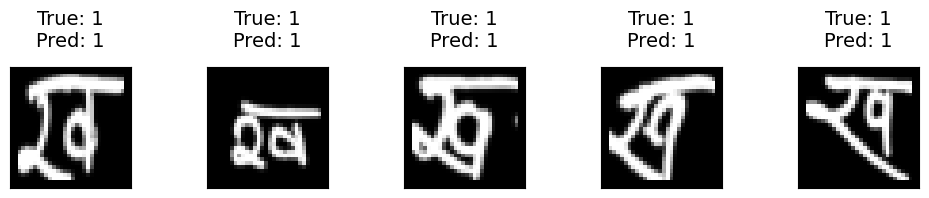

In [ ]:
import random
import matplotlib.pyplot as plt

def show_images_grid(images, labels, predicted, num_images=5):
    ncols = int(np.ceil(num_images))
    nrows = int(np.ceil(1))

    # Adjust figure size for smaller images
    _, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 2, 2))  # Decrease figsize for smaller images
    axes = axes.flatten()

    for ax_i, ax in enumerate(axes):
        if ax_i < num_images:
            ax.imshow(images[ax_i].cpu().numpy().squeeze(), cmap='gray')
            # Display True and Pred labels
            ax.set_title(f'True: {labels[ax_i].item()}\nPred: {predicted[ax_i].item()}',
                         fontsize=14, y=1.1)
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Select a random batch of images for prediction
def get_random_batch(loader):
    # Convert the DataLoader to a list and pick a random batch
    batch = random.choice(list(loader))
    return batch

# Usage: Select a random batch from the test set
images, labels = get_random_batch(test_loader)
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

show_images_grid(images, labels, predicted)
